In [1]:
# ===================================================================
# PIPELINE : Two Layer LSTM -> TabNet -> Ridge
# TARGET: Minimize RMSE and SMAPE for IHSG Closing Price Prediction
# ===================================================================

# -------------------
# 1. Imports & Config
# -------------------
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Input, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from pytorch_tabnet.metrics import Metric # Import Metric class
import shap

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.random.set_seed(42)
np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# ---------------------
# 2. Data Preparation
# ---------------------
print("--- Loading and Preparing Data ---")
start_date = "2010-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

variables = {
    "IHSG": "^JKSE", "S&P 500": "^GSPC", "Nasdaq": "^IXIC", "VIX": "^VIX",
    "Hang Seng Index": "^HSI", "Crude Oil (WTI)": "CL=F", "Gold": "GC=F",
    "USD/IDR": "IDR=X", "DAX": "^GDAXI", "Crude Oil (Brent)": "BZ=F",
    "EUR/USD": "EURUSD=X", "Copper": "HG=F", "Silver": "SI=F"
}
data_ohlc = yf.download(list(variables.values()), start=start_date, end=end_date, auto_adjust=False)

# --- RESEARCH STEP 1: Isolate, Show, and Export Raw IHSG Data ---
ihsg_raw_df = data_ohlc.loc[:, (slice(None), '^JKSE')]
ihsg_raw_df.columns = ihsg_raw_df.columns.droplevel(1)
ihsg_raw_df.dropna(inplace=True)

print("\n--- Raw IHSG Data Snapshot (Tabel 1. Data IHSG) ---")
print(ihsg_raw_df.head().reset_index().to_string())
print(f"\n{len(ihsg_raw_df)} rows x {len(ihsg_raw_df.columns)} columns")
ihsg_raw_df.to_csv('raw_ihsg_data_tabnet.csv')
print("Raw IHSG OHLCVA data exported to 'raw_ihsg_data_tabnet.csv'")

# --- Continue with the full dataset for feature engineering ---
data = data_ohlc['Close'].copy()
volume = data_ohlc['Volume'].copy()
data.rename(columns={v: k for k, v in variables.items()}, inplace=True)
volume.rename(columns={v: f"{k}_Volume" for k, v in variables.items()}, inplace=True)


try:
    fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
    data = data.join(fed_rate)
    data.rename(columns={'FEDFUNDS': 'Federal Funds Rate (Effective)'}, inplace=True)
    variables["Federal Funds Rate (Effective)"] = "Federal Funds Rate (Effective)"
except Exception as e:
    print(f"Could not fetch FEDFUNDS data. Error: {e}")

data = data.join(volume)
data.dropna(axis=1, how='all', inplace=True)
data = data.ffill().bfill()

# --- Feature Engineering ---
print("\n--- Performing Advanced Feature Engineering ---")

# --- TECHNICAL INDICATORS (Manual Calculation) ---
exp1 = data['IHSG'].ewm(span=12, adjust=False).mean()
exp2 = data['IHSG'].ewm(span=26, adjust=False).mean()
data['MACD_12_26_9'] = exp1 - exp2
data['MACDs_12_26_9'] = data['MACD_12_26_9'].ewm(span=9, adjust=False).mean()
data['MACDh_12_26_9'] = data['MACD_12_26_9'] - data['MACDs_12_26_9']
delta = data['IHSG'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['BBM_20_2.0'] = data['IHSG'].rolling(window=20).mean()
std_dev = data['IHSG'].rolling(window=20).std()
data['BBU_20_2.0'] = data['BBM_20_2.0'] + (std_dev * 2)
data['BBL_20_2.0'] = data['BBM_20_2.0'] - (std_dev * 2)

# --- ENGINEERED FEATURES & TIME-BASED FEATURES ---
for col in variables.keys():
    if col != 'IHSG' and col in data.columns:
        for lag in [1, 2, 3, 5, 10, 21]:
            data[f'{col}_pct_change_{lag}d'] = data[col].pct_change(lag)

data['Gold_vs_SP500'] = data['Gold'] / data['S&P 500']
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
data['DayOfYear'] = data.index.dayofyear
data.dropna(inplace=True)

# --- RESEARCH STEP 2: Show and Export Featured Data ---
print("\n--- Featured Data Snapshot ---")
print(data.head())
data.to_csv('featured_data_tabnet.csv')
print("Featured data exported to 'featured_data_tabnet.csv'")

# ---------------------------
# 3. Data for Price Prediction
# ---------------------------
data['Target'] = data['IHSG'].shift(-1)
data.dropna(inplace=True)

features = [col for col in data.columns if col not in ['Target', 'IHSG']]
X = data[features]
y = data['Target']

categorical_cols = ['DayOfWeek', 'Month', 'WeekOfYear', 'DayOfYear']
categorical_idxs = [features.index(col) for col in categorical_cols]
categorical_dims = [len(X[col].unique()) for col in categorical_cols]

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTotal data rows after feature engineering and cleaning: {len(X)}")
print(f"Total training data rows: {len(X_train)}")
print(f"Total test data rows: {len(X_test)}")

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

# --- RESEARCH STEP 3: Show Scaled Data ---
print("\n--- Scaled Training Data Snapshot (First 5 Rows) ---")
print(X_train_scaled[:5])

/home/rangga/metopen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-14 08:25:21.835757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752456321.856554    8885 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752456321.862883    8885 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752456321.885943    8885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0

--- Loading and Preparing Data ---


[*********************100%***********************]  13 of 13 completed



--- Raw IHSG Data Snapshot (Tabel 1. Data IHSG) ---
Price       Date    Adj Close        Close         High          Low         Open      Volume
0     2010-01-04  2575.312988  2575.413086  2576.055908  2532.895996  2533.947998  18339300.0
1     2010-01-05  2605.175537  2605.277100  2606.069092  2575.616943  2575.616943  57043800.0
2     2010-01-06  2603.195557  2603.297119  2622.115967  2587.709961  2605.480957  51569100.0
3     2010-01-07  2586.794189  2586.895020  2611.603027  2570.272949  2603.500977  45510800.0
4     2010-01-08  2614.268311  2614.370117  2614.535889  2583.846924  2586.792969  73723500.0

3767 rows x 6 columns
Raw IHSG OHLCVA data exported to 'raw_ihsg_data_tabnet.csv'

--- Performing Advanced Feature Engineering ---

--- Featured Data Snapshot ---
            Crude Oil (Brent)  Crude Oil (WTI)   EUR/USD         Gold  Copper  \
Date                                                                            
2010-02-01          73.110001        74.430000  1.392699 

In [3]:
# %%
# -----------------------------------
# 4. Improved LSTM Model (Enhanced)
# -----------------------------------
print("\n--- Training Improved LSTM Model ---")

# Feature selection for LSTM
from sklearn.feature_selection import SelectKBest, f_regression

def create_sequences(X, y, time_steps):
    """
    Create sequences for LSTM training
    
    Parameters:
    X: Input features (2D array)
    y: Target values (1D array)
    time_steps: Number of time steps to look back
    
    Returns:
    X_seq: 3D array of shape (samples, time_steps, features)
    y_seq: 1D array of target values
    """
    X_seq, y_seq = [], []
    
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)

def select_best_features_lstm(X_train, y_train, features, k=30):
    """Select top k features for LSTM"""
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X_train, y_train)
    selected_features = [features[i] for i in selector.get_support(indices=True)]
    return X_selected, selected_features, selector

# Select best features for LSTM
X_train_selected, selected_features_lstm, feature_selector = select_best_features_lstm(
    X_train_scaled, y_train_scaled.ravel(), features, k=30
)
X_test_selected = feature_selector.transform(X_test_scaled)

print(f"Selected {len(selected_features_lstm)} features for LSTM")

# Find optimal sequence length
def find_optimal_time_steps(X_train, y_train, test_lengths=[20, 40, 60, 80]):
    """Find optimal sequence length"""
    best_score = float('inf')
    best_length = 60
    
    for length in test_lengths:
        if len(X_train) <= length:
            continue
            
        X_seq, y_seq = create_sequences(X_train, y_train, length)
        if len(X_seq) < 100:
            continue
            
        # Quick test model
        inputs = Input(shape=(X_seq.shape[1], X_seq.shape[2]))
        x = LSTM(50)(inputs)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        test_model = Model(inputs=inputs, outputs=outputs)
        test_model.compile(optimizer=Adam(0.001), loss='mse')
        
        history = test_model.fit(
            X_seq[:800], y_seq[:800], epochs=15, batch_size=32,
            validation_split=0.2, verbose=2,
            callbacks=[EarlyStopping(patience=5)]
        )
        
        val_loss = min(history.history['val_loss'])
        if val_loss < best_score:
            best_score = val_loss
            best_length = length
            
        del test_model
        tf.keras.backend.clear_session()
    
    return best_length

# Find optimal TIME_STEPS
optimal_time_steps = find_optimal_time_steps(X_train_selected, y_train_scaled)
TIME_STEPS = optimal_time_steps
print(f"Optimal TIME_STEPS: {TIME_STEPS}")

# Create sequences with optimal length
X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, TIME_STEPS)

# Walk-forward validation for hyperparameter tuning
def walk_forward_splits(X, y, n_splits=3):
    """Create walk-forward validation splits"""
    n_samples = len(X)
    min_train_size = int(n_samples * 0.6)
    step_size = (n_samples - min_train_size) // n_splits
    
    splits = []
    for i in range(n_splits):
        train_end = min_train_size + (i * step_size)
        test_start = train_end
        test_end = min(train_end + step_size, n_samples)
        
        if test_end > n_samples or test_start >= test_end:
            break
            
        splits.append((np.arange(0, train_end), np.arange(test_start, test_end)))
    
    return splits

def objective_lstm(trial):
    # Enhanced hyperparameters
    units1 = trial.suggest_int('units1', 64, 200, step=16)
    units2 = trial.suggest_int('units2', 32, 100, step=16)
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.4)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # Walk-forward validation
    splits = walk_forward_splits(X_train_seq, y_train_seq)
    fold_scores = []
    
    for train_idx, val_idx in splits:
        # Create model for this fold
        inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
        x = LSTM(units1, return_sequences=True, 
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(inputs)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Dropout(dropout1)(x)
        
        x = LSTM(units2, return_sequences=False,
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Dropout(dropout2)(x)
        
        outputs = Dense(1)(x)
        model = Model(inputs=inputs, outputs=outputs)
        
        # Use Huber loss for robustness
        model.compile(optimizer=Adam(lr), loss=tf.keras.losses.Huber(delta=1.0))
        
        # Train on fold
        X_fold_train = X_train_seq[train_idx]
        y_fold_train = y_train_seq[train_idx]
        X_fold_val = X_train_seq[val_idx]
        y_fold_val = y_train_seq[val_idx]
        
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=50, batch_size=batch_size, verbose=2,
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            ]
        )
        
        val_loss = min(history.history['val_loss'])
        fold_scores.append(val_loss)
        
        del model
        tf.keras.backend.clear_session()
    
    mean_score = np.mean(fold_scores)
    print(f"  Trial {trial.number} CV score: {mean_score:.6f}")
    return mean_score

# Hyperparameter optimization with walk-forward validation
study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=20)
best_lstm_params = study_lstm.best_params
print(f"\nBest Params Found ===> {best_lstm_params}")



--- Training Improved LSTM Model ---
Selected 30 features for LSTM
Epoch 1/15


2025-07-14 08:27:43.231185: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 - 2s - 94ms/step - loss: 0.0304 - val_loss: 0.0090
Epoch 2/15
20/20 - 0s - 12ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 3/15
20/20 - 0s - 13ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 4/15
20/20 - 0s - 12ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 5/15
20/20 - 2s - 89ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 6/15
20/20 - 0s - 12ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 7/15
20/20 - 0s - 12ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/15
20/20 - 0s - 12ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 9/15
20/20 - 0s - 12ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/15
20/20 - 0s - 12ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 11/15
20/20 - 0s - 12ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 12/15
20/20 - 0s - 12ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 13/15
20/20 - 0s - 12ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 14/15
20/20 - 0s - 12ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 1/15
20/20 - 2s - 82ms/step - loss: 0.0140 - val

Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1036 - mae: 0.2657 - mse: 0.1858

85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.1030 - mae: 0.2644 - mse: 0.1844 - val_loss: 0.0248 - val_mae: 0.1036 - val_mse: 0.0166 - learning_rate: 0.0098
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0195 - mae: 0.0744 - mse: 0.0089

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0195 - mae: 0.0744 - mse: 0.0089 - val_loss: 0.0232 - val_mae: 0.1316 - val_mse: 0.0237 - learning_rate: 0.0098
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0137 - mae: 0.0634 - mse: 0.0064

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0137 - mae: 0.0634 - mse: 0.0064 - val_loss: 0.0191 - val_mae: 0.1264 - val_mse: 0.0217 - learning_rate: 0.0098
Epoch 4/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0101 - mae: 0.0535 - mse: 0.0048

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0100 - mae: 0.0535 - mse: 0.0048 - val_loss: 0.0136 - val_mae: 0.1037 - val_mse: 0.0150 - learning_rate: 0.0098
Epoch 5/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0075 - mae: 0.0457 - mse: 0.0036

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0075 - mae: 0.0457 - mse: 0.0036 - val_loss: 0.0106 - val_mae: 0.0923 - val_mse: 0.0121 - learning_rate: 0.0098
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0060 - mae: 0.0442 - mse: 0.0033

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0060 - mae: 0.0441 - mse: 0.0033 - val_loss: 0.0097 - val_mae: 0.0937 - val_mse: 0.0124 - learning_rate: 0.0098
Epoch 7/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0047 - mae: 0.0410 - mse: 0.0028

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0047 - mae: 0.0410 - mse: 0.0028 - val_loss: 0.0087 - val_mae: 0.0908 - val_mse: 0.0119 - learning_rate: 0.0098
Epoch 8/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0039 - mae: 0.0380 - mse: 0.0024

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0039 - mae: 0.0381 - mse: 0.0024 - val_loss: 0.0085 - val_mae: 0.0935 - val_mse: 0.0125 - learning_rate: 0.0098
Epoch 9/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0032 - mae: 0.0347 - mse: 0.0021

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0032 - mae: 0.0347 - mse: 0.0021 - val_loss: 0.0080 - val_mae: 0.0949 - val_mse: 0.0125 - learning_rate: 0.0098
Epoch 10/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0029 - mae: 0.0379 - mse: 0.0024 - val_loss: 0.0083 - val_mae: 0.0992 - val_mse: 0.0137 - learning_rate: 0.0098
Epoch 11/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0023 - mae: 0.0319 - mse: 0.0017

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0023 - mae: 0.0319 - mse: 0.0017 - val_loss: 0.0054 - val_mae: 0.0742 - val_mse: 0.0084 - learning_rate: 0.0098
Epoch 12/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0021 - mae: 0.0335 - mse: 0.0019

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0021 - mae: 0.0335 - mse: 0.0019 - val_loss: 0.0054 - val_mae: 0.0736 - val_mse: 0.0086 - learning_rate: 0.0098
Epoch 13/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0020 - mae: 0.0328 - mse: 0.0018

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0020 - mae: 0.0328 - mse: 0.0018 - val_loss: 0.0047 - val_mae: 0.0680 - val_mse: 0.0075 - learning_rate: 0.0098
Epoch 14/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0018 - mae: 0.0320 - mse: 0.0017 - val_loss: 0.0098 - val_mae: 0.1202 - val_mse: 0.0181 - learning_rate: 0.0098
Epoch 15/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0017 - mae: 0.0328 - mse: 0.0018 - val_loss: 0.0061 - val_mae: 0.0853 - val_mse: 0.0107 - learning_rate: 0.0098
Epoch 16/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0016 - mae: 0.0314 - mse: 0.0017 - val_loss: 0.0047 - val_mae: 0.0726 - val_mse: 0.0081 - learning_rate: 0.0098
Epoch 17/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015 - mae: 0.0320 - mse: 0.0018

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0015 - mae: 0.0320 - mse: 0.0018 - val_loss: 0.0046 - val_mae: 0.0725 - val_mse: 0.0079 - learning_rate: 0.0098
Epoch 18/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0014 - mae: 0.0306 - mse: 0.0016 - val_loss: 0.0050 - val_mae: 0.0773 - val_mse: 0.0088 - learning_rate: 0.0098
Epoch 19/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0014 - mae: 0.0313 - mse: 0.0017 - val_loss: 0.0050 - val_mae: 0.0785 - val_mse: 0.0090 - learning_rate: 0.0098
Epoch 20/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0013 - mae: 0.0298 - mse: 0.0015 - val_loss: 0.0058 - val_mae: 0.0862 - val_mse: 0.0105 - learning_rate: 0.0098
Epoch 21/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0014 - mae: 0.0312 - mse: 0.0017 - val_loss: 0.0057 - val_mae: 0.0853 - val_mse: 0.0103 - learning_rate: 0.0098
Epoch 22/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0015 - mae: 0.0334 - mse: 0.0019

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0015 - mae: 0.0334 - mse: 0.0019 - val_loss: 0.0045 - val_mae: 0.0718 - val_mse: 0.0079 - learning_rate: 0.0098
Epoch 23/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0013 - mae: 0.0295 - mse: 0.0015

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0013 - mae: 0.0295 - mse: 0.0015 - val_loss: 0.0035 - val_mae: 0.0625 - val_mse: 0.0060 - learning_rate: 0.0098
Epoch 24/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0014 - mae: 0.0320 - mse: 0.0017 - val_loss: 0.0037 - val_mae: 0.0655 - val_mse: 0.0065 - learning_rate: 0.0098
Epoch 25/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0013 - mae: 0.0308 - mse: 0.0016 - val_loss: 0.0055 - val_mae: 0.0862 - val_mse: 0.0100 - learning_rate: 0.0098
Epoch 26/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0014 - mae: 0.0336 - mse: 0.0019 - val_loss: 0.0046 - val_mae: 0.0760 - val_mse: 0.0081 - learning_rate: 0.0098
Epoch 27/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0013 - mae: 0.0315 - mse: 0.0017 - val_loss: 0.0054 - val_mae: 0.0856 - val_mse: 0.0099 - learning_rate: 0.0098
Epoch 28/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0012 - mae: 0.0291 - mse: 0.0014

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0012 - mae: 0.0291 - mse: 0.0014 - val_loss: 0.0032 - val_mae: 0.0595 - val_mse: 0.0055 - learning_rate: 0.0098
Epoch 29/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0012 - mae: 0.0305 - mse: 0.0016

85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0012 - mae: 0.0305 - mse: 0.0016 - val_loss: 0.0029 - val_mae: 0.0563 - val_mse: 0.0050 - learning_rate: 0.0098
Epoch 30/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0013 - mae: 0.0311 - mse: 0.0016 - val_loss: 0.0031 - val_mae: 0.0590 - val_mse: 0.0053 - learning_rate: 0.0098
Epoch 31/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0015 - mae: 0.0347 - mse: 0.0021 - val_loss: 0.0047 - val_mae: 0.0762 - val_mse: 0.0084 - learning_rate: 0.0098
Epoch 32/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0012 - mae: 0.0297 - mse: 0.0015 - val_loss: 0.0044 - val_mae: 0.0737 - val_mse: 0.0079 - learning_rate: 0.0098
Epoch 33/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0012 - mae: 0.0293 - mse: 0.0014

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0012 - mae: 0.0293 - mse: 0.0014 - val_loss: 0.0018 - val_mae: 0.0394 - val_mse: 0.0027 - learning_rate: 0.0098
Epoch 34/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0012 - mae: 0.0306 - mse: 0.0015 - val_loss: 0.0053 - val_mae: 0.0896 - val_mse: 0.0098 - learning_rate: 0.0098
Epoch 35/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0013 - mae: 0.0311 - mse: 0.0017 - val_loss: 0.0035 - val_mae: 0.0659 - val_mse: 0.0062 - learning_rate: 0.0098
Epoch 36/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0012 - mae: 0.0297 - mse: 0.0015 - val_loss: 0.0040 - val_mae: 0.0707 - val_mse: 0.0070 - learning_rate: 0.0098
Epoch 37/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0012 - mae: 0.0302 - mse: 0.0016 - val_loss: 0.0025 - val_mae: 0.0484 - val_mse: 0.0041 - learning_rate: 0.0098
Epoch 38/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0013 - mae: 0.0306 - mse: 0.0016 - val_loss: 0.0030 - val_mae: 0.0566 - val

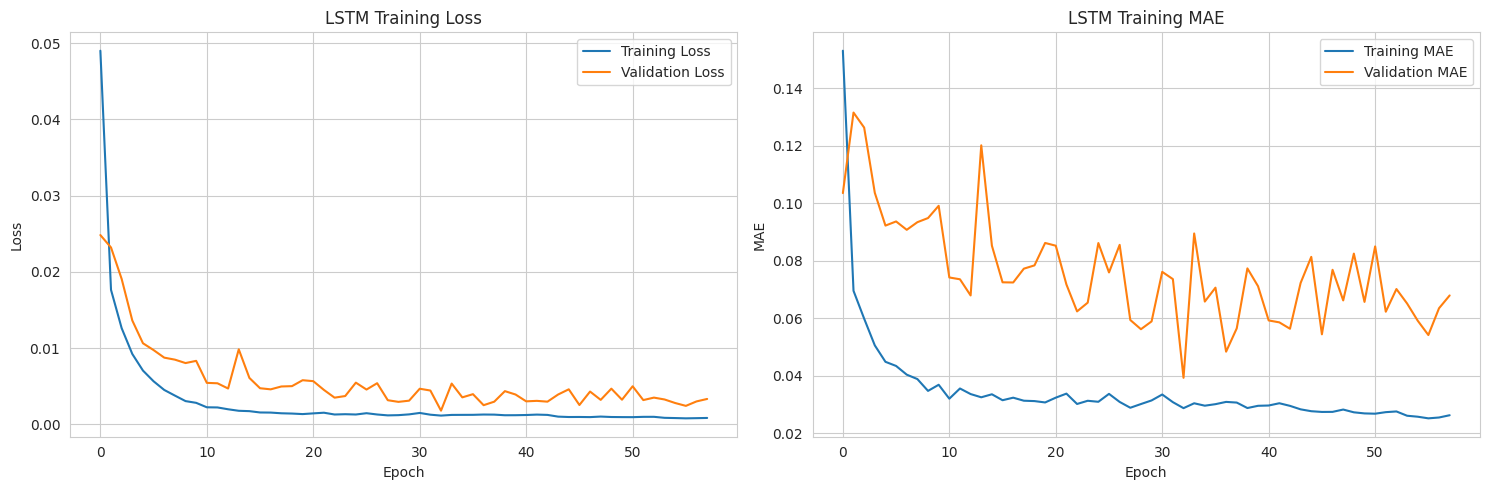

LSTM model trained with 30 features and 40 time steps


In [4]:
# Build final model with enhancements
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = LSTM(best_lstm_params['units1'], return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(inputs)

if best_lstm_params.get('use_batch_norm', False):
    x = BatchNormalization()(x)
x = Dropout(best_lstm_params['dropout1'])(x)

x = LSTM(best_lstm_params['units2'], return_sequences=False,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(x)

if best_lstm_params.get('use_batch_norm', False):
    x = BatchNormalization()(x)
x = Dropout(best_lstm_params['dropout2'])(x)

outputs = Dense(1)(x)
final_lstm = Model(inputs=inputs, outputs=outputs)

# Enhanced compilation and training
final_lstm.compile(
    optimizer=Adam(best_lstm_params['lr']), 
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mse', 'mae']
)

# Enhanced callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')
]

# Train final model
history = final_lstm.fit(
    X_train_seq, y_train_seq, 
    epochs=150, 
    batch_size=best_lstm_params.get('batch_size', 32),
    validation_split=0.15, 
    callbacks=callbacks, 
    verbose=1
)

# Generate predictions
lstm_pred_train_scaled = final_lstm.predict(X_train_seq)
lstm_pred_test_scaled = final_lstm.predict(X_test_seq)

# Training visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"LSTM model trained with {len(selected_features_lstm)} features and {TIME_STEPS} time steps")

In [5]:
# ------------------------------
# 5. TabNet Model (Tuned with Fixed Batch Size)
# ------------------------------
print("\n--- Training TabNet Model with Optuna ---")
X_train_tabular = X_train_scaled[TIME_STEPS:]
X_test_tabular = X_test_scaled[TIME_STEPS:]
y_train_tabular = y_train_seq
y_test_tabular = y_test_seq

def objective_tabnet(trial):
    # Batch size is now fixed
    batch_size = 128
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64), 'n_a': trial.suggest_int('n_a', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 3, 10), 'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax']),
        'cat_idxs': categorical_idxs, 'cat_dims': categorical_dims, 'cat_emb_dim': trial.suggest_int("cat_emb_dim", 1, 3),
        'optimizer_fn': torch.optim.Adam, 'optimizer_params': dict(lr=trial.suggest_float('lr', 1e-3, 3e-2, log=True)),
    }
    
    model = TabNetRegressor(**params, seed=42, verbose=2)
    model.fit(
        X_train=X_train_tabular, y_train=y_train_tabular, 
        eval_set=[(X_test_tabular, y_test_tabular)], 
        eval_metric=['mse'], 
        max_epochs=200, patience=30, 
        batch_size=batch_size,
        virtual_batch_size=64
    )
    return model.best_cost

study_tabnet = optuna.create_study(direction='minimize')
study_tabnet.optimize(objective_tabnet, n_trials=30)
best_tabnet_params = study_tabnet.best_params

print("\n--- Best TabNet Parameters Found by Optuna ---")
print(best_tabnet_params)



--- Training TabNet Model with Optuna ---
epoch 0  | loss: 1.64914 | val_0_mse: 0.83889 |  0:00:01s
epoch 2  | loss: 0.5485  | val_0_mse: 0.34589 |  0:00:03s
epoch 4  | loss: 0.25654 | val_0_mse: 0.19058 |  0:00:05s
epoch 6  | loss: 0.14956 | val_0_mse: 0.1818  |  0:00:07s
epoch 8  | loss: 0.0914  | val_0_mse: 0.13082 |  0:00:09s
epoch 10 | loss: 0.0604  | val_0_mse: 0.05707 |  0:00:11s
epoch 12 | loss: 0.03886 | val_0_mse: 0.05254 |  0:00:13s
epoch 14 | loss: 0.02924 | val_0_mse: 0.05202 |  0:00:17s
epoch 16 | loss: 0.02355 | val_0_mse: 0.02646 |  0:00:19s
epoch 18 | loss: 0.01788 | val_0_mse: 0.0452  |  0:00:22s
epoch 20 | loss: 0.0148  | val_0_mse: 0.02988 |  0:00:24s
epoch 22 | loss: 0.01489 | val_0_mse: 0.02656 |  0:00:26s
epoch 24 | loss: 0.01235 | val_0_mse: 0.02888 |  0:00:28s
epoch 26 | loss: 0.00999 | val_0_mse: 0.02187 |  0:00:30s
epoch 28 | loss: 0.01023 | val_0_mse: 0.03364 |  0:00:32s
epoch 30 | loss: 0.00856 | val_0_mse: 0.02507 |  0:00:34s
epoch 32 | loss: 0.00918 | va

In [6]:
# FIXED: Remove 'lr' from the dictionary before initializing the final model
best_tabnet_params.pop('lr', None)

# Build final TabNet model with best params
final_tabnet = TabNetRegressor(**best_tabnet_params, seed=42, verbose=2)
final_tabnet.fit(
    X_train=X_train_tabular, y_train=y_train_tabular, 
    eval_set=[(X_test_tabular, y_test_tabular)], 
    eval_metric=['mse'], 
    max_epochs=200, patience=30, 
    batch_size=128, 
    virtual_batch_size=64
)

tabnet_pred_train_scaled = final_tabnet.predict(X_train_tabular).reshape(-1, 1)
tabnet_pred_test_scaled = final_tabnet.predict(X_test_tabular).reshape(-1, 1)


epoch 0  | loss: 6.50768 | val_0_mse: 0.36824 |  0:00:01s
epoch 2  | loss: 0.76607 | val_0_mse: 0.16973 |  0:00:05s
epoch 4  | loss: 0.15388 | val_0_mse: 0.16855 |  0:00:10s
epoch 6  | loss: 0.02099 | val_0_mse: 0.01504 |  0:00:14s
epoch 8  | loss: 0.01465 | val_0_mse: 0.02536 |  0:00:18s
epoch 10 | loss: 0.01464 | val_0_mse: 0.01875 |  0:00:22s
epoch 12 | loss: 0.01015 | val_0_mse: 0.0422  |  0:00:25s
epoch 14 | loss: 0.01098 | val_0_mse: 0.01636 |  0:00:28s
epoch 16 | loss: 0.00658 | val_0_mse: 0.03503 |  0:00:32s
epoch 18 | loss: 0.00704 | val_0_mse: 0.0262  |  0:00:35s
epoch 20 | loss: 0.00797 | val_0_mse: 0.04169 |  0:00:39s
epoch 22 | loss: 0.00685 | val_0_mse: 0.00993 |  0:00:44s
epoch 24 | loss: 0.00657 | val_0_mse: 0.01214 |  0:00:48s
epoch 26 | loss: 0.00706 | val_0_mse: 0.01581 |  0:00:51s
epoch 28 | loss: 0.00567 | val_0_mse: 0.02966 |  0:00:55s
epoch 30 | loss: 0.00604 | val_0_mse: 0.02003 |  0:00:59s
epoch 32 | loss: 0.00633 | val_0_mse: 0.01419 |  0:01:02s
epoch 34 | los

In [7]:
# -----------------------------------
# 6. Improved Ridge Meta Learner
# -----------------------------------
print("\n--- Training Improved Ensemble Model ---")
meta_train = np.hstack([X_train_tabular, lstm_pred_train_scaled, tabnet_pred_train_scaled])
meta_test = np.hstack([X_test_tabular, lstm_pred_test_scaled, tabnet_pred_test_scaled])
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_train, y_train_tabular.ravel())
final_pred_scaled = meta_model.predict(meta_test)


--- Training Improved Ensemble Model ---



--- Final Combined Model Metrics ---
                    Model        RMSE         MAE        R2  SMAPE (%)
0         Standalone LSTM  254.065944  201.417201  0.266022   2.862949
1                  TabNet  379.145406  289.612966 -0.634563   4.084782
2  Ensemble (LSTM+TabNet)   82.399173   63.146543  0.922797   0.898103


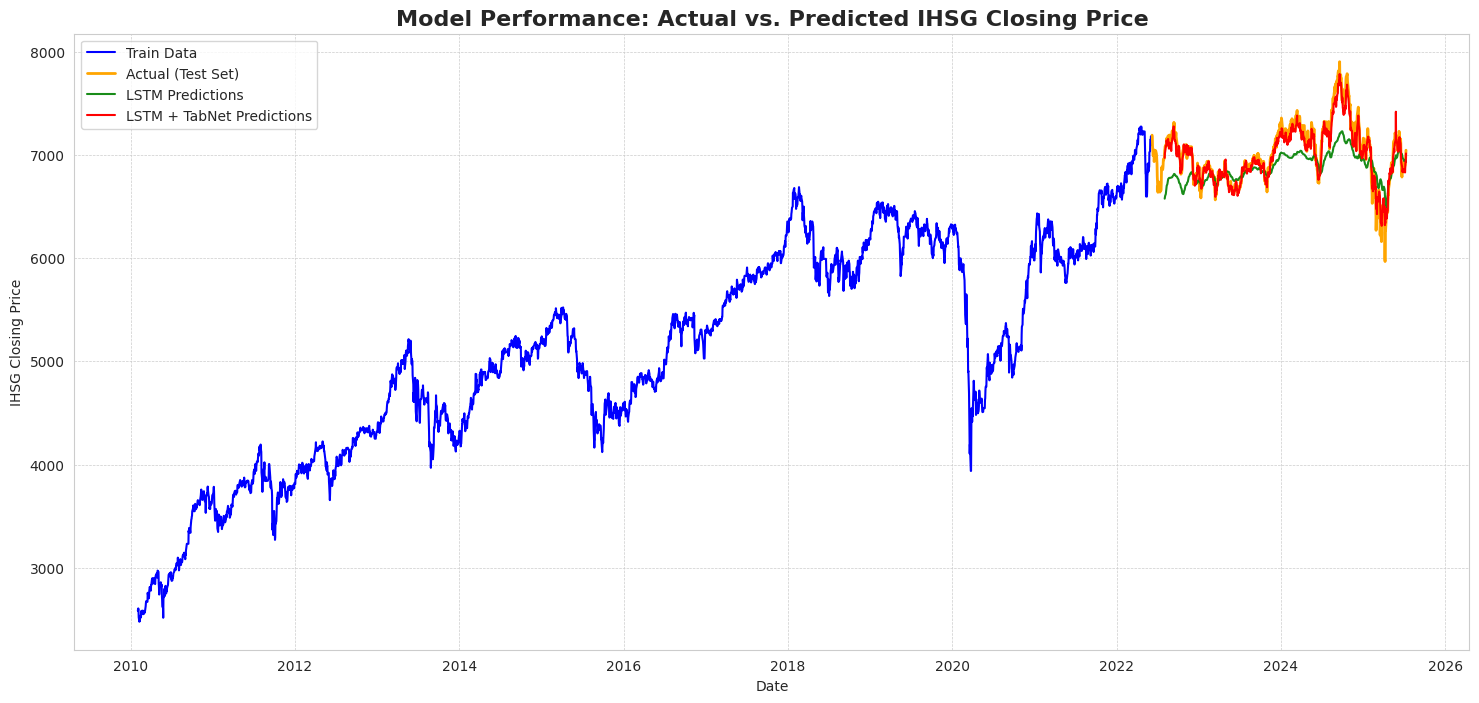

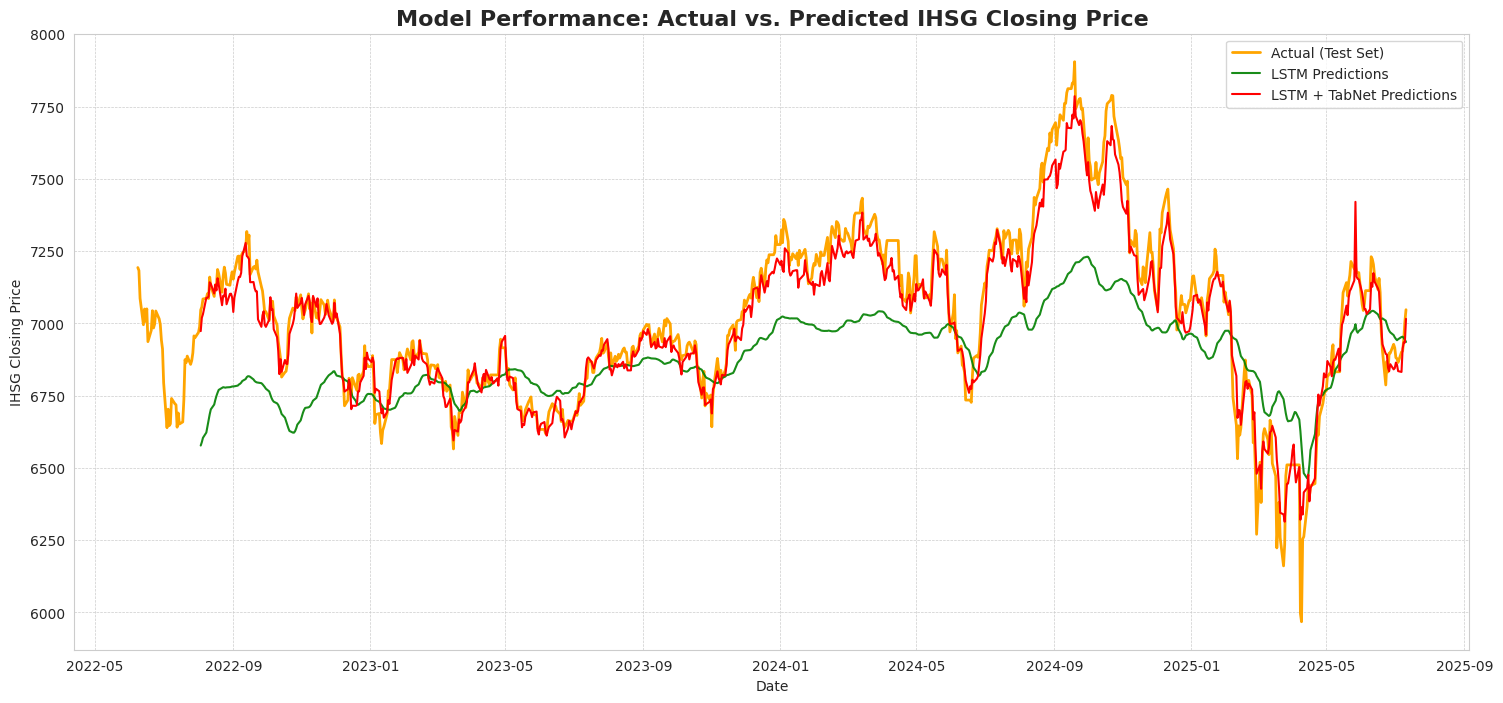

In [8]:
# ------------------------------
# 7. Reconstruct actual prices & Evaluate
# ------------------------------
final_pred = scaler_y.inverse_transform(final_pred_scaled.reshape(-1, 1)).flatten()
lstm_pred = scaler_y.inverse_transform(lstm_pred_test_scaled).flatten()
tabnet_pred = scaler_y.inverse_transform(tabnet_pred_test_scaled).flatten()
y_test_actual = y_test.iloc[TIME_STEPS:].values

def calculate_metrics(y_true, y_pred, model_name="Final Model"):
    metrics = {'Model': model_name, 'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)), 'MAE': mean_absolute_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred), 'SMAPE (%)': 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true)/(np.abs(y_true) + np.abs(y_pred) + 1e-8))}
    return metrics

metrics_final = calculate_metrics(y_test_actual, final_pred, "Ensemble (LSTM+TabNet)")
metrics_lstm = calculate_metrics(y_test_actual, lstm_pred, "Standalone LSTM")
metrics_tabnet = calculate_metrics(y_test_actual, tabnet_pred, "TabNet")
results_df = pd.DataFrame([metrics_lstm, metrics_tabnet,metrics_final])

print("\n--- Final Combined Model Metrics ---")
print(results_df.to_string())

# --- REVISED PLOTTING LOGIC TO REMOVE GAP ---
train_data = data[:train_size]
valid_data = data[train_size:].copy()
prediction_dates = y_test.index[TIME_STEPS:]
valid_data['Predictions'] = np.nan
valid_data.loc[prediction_dates, 'Predictions'] = final_pred
valid_data['LSTM_Predictions'] = np.nan
valid_data.loc[prediction_dates, 'LSTM_Predictions'] = lstm_pred


# Plotting
plt.figure(figsize=(18, 8))
plt.title('Model Performance: Actual vs. Predicted IHSG Closing Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.plot(train_data['IHSG'], label='Train Data', color='blue')
plt.plot(valid_data['IHSG'], label='Actual (Test Set)', color='orange', linewidth=2)
plt.plot(valid_data['LSTM_Predictions'], label='LSTM Predictions', color='green', alpha=0.9)
plt.plot(valid_data['Predictions'], label='LSTM + TabNet Predictions', color='red')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# without the training data
plt.figure(figsize=(18, 8))
plt.title('Model Performance: Actual vs. Predicted IHSG Closing Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.plot(valid_data['IHSG'], label='Actual (Test Set)', color='orange', linewidth=2)
plt.plot(valid_data['LSTM_Predictions'], label='LSTM Predictions', color='green', alpha=0.9)
plt.plot(valid_data['Predictions'], label='LSTM + TabNet Predictions', color='red')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



Performing TabNet categorical analysis...

--- Top 15 Overall Feature Importance (TabNet) ---
                           Feature  Importance
7                              DAX    0.233172
31                      BBU_20_2.0    0.114055
12  Federal Funds Rate (Effective)    0.081276
42            Nasdaq_pct_change_5d    0.072856
24                     IHSG_Volume    0.046689
98           Copper_pct_change_21d    0.044595
8                          S&P 500    0.042084
32                      BBL_20_2.0    0.033732
52   Hang Seng Index_pct_change_2d    0.029709
37          S&P 500_pct_change_10d    0.026951
18                  USD/IDR_Volume    0.025452
68             Gold_pct_change_21d    0.020431
57   Crude Oil (WTI)_pct_change_1d    0.018372
78               DAX_pct_change_5d    0.017928
93            Copper_pct_change_1d    0.017575

--- Feature Importance by Category ---
           Category  Total_Importance
1    Global Markets          0.470031
2       Commodities          0.173369

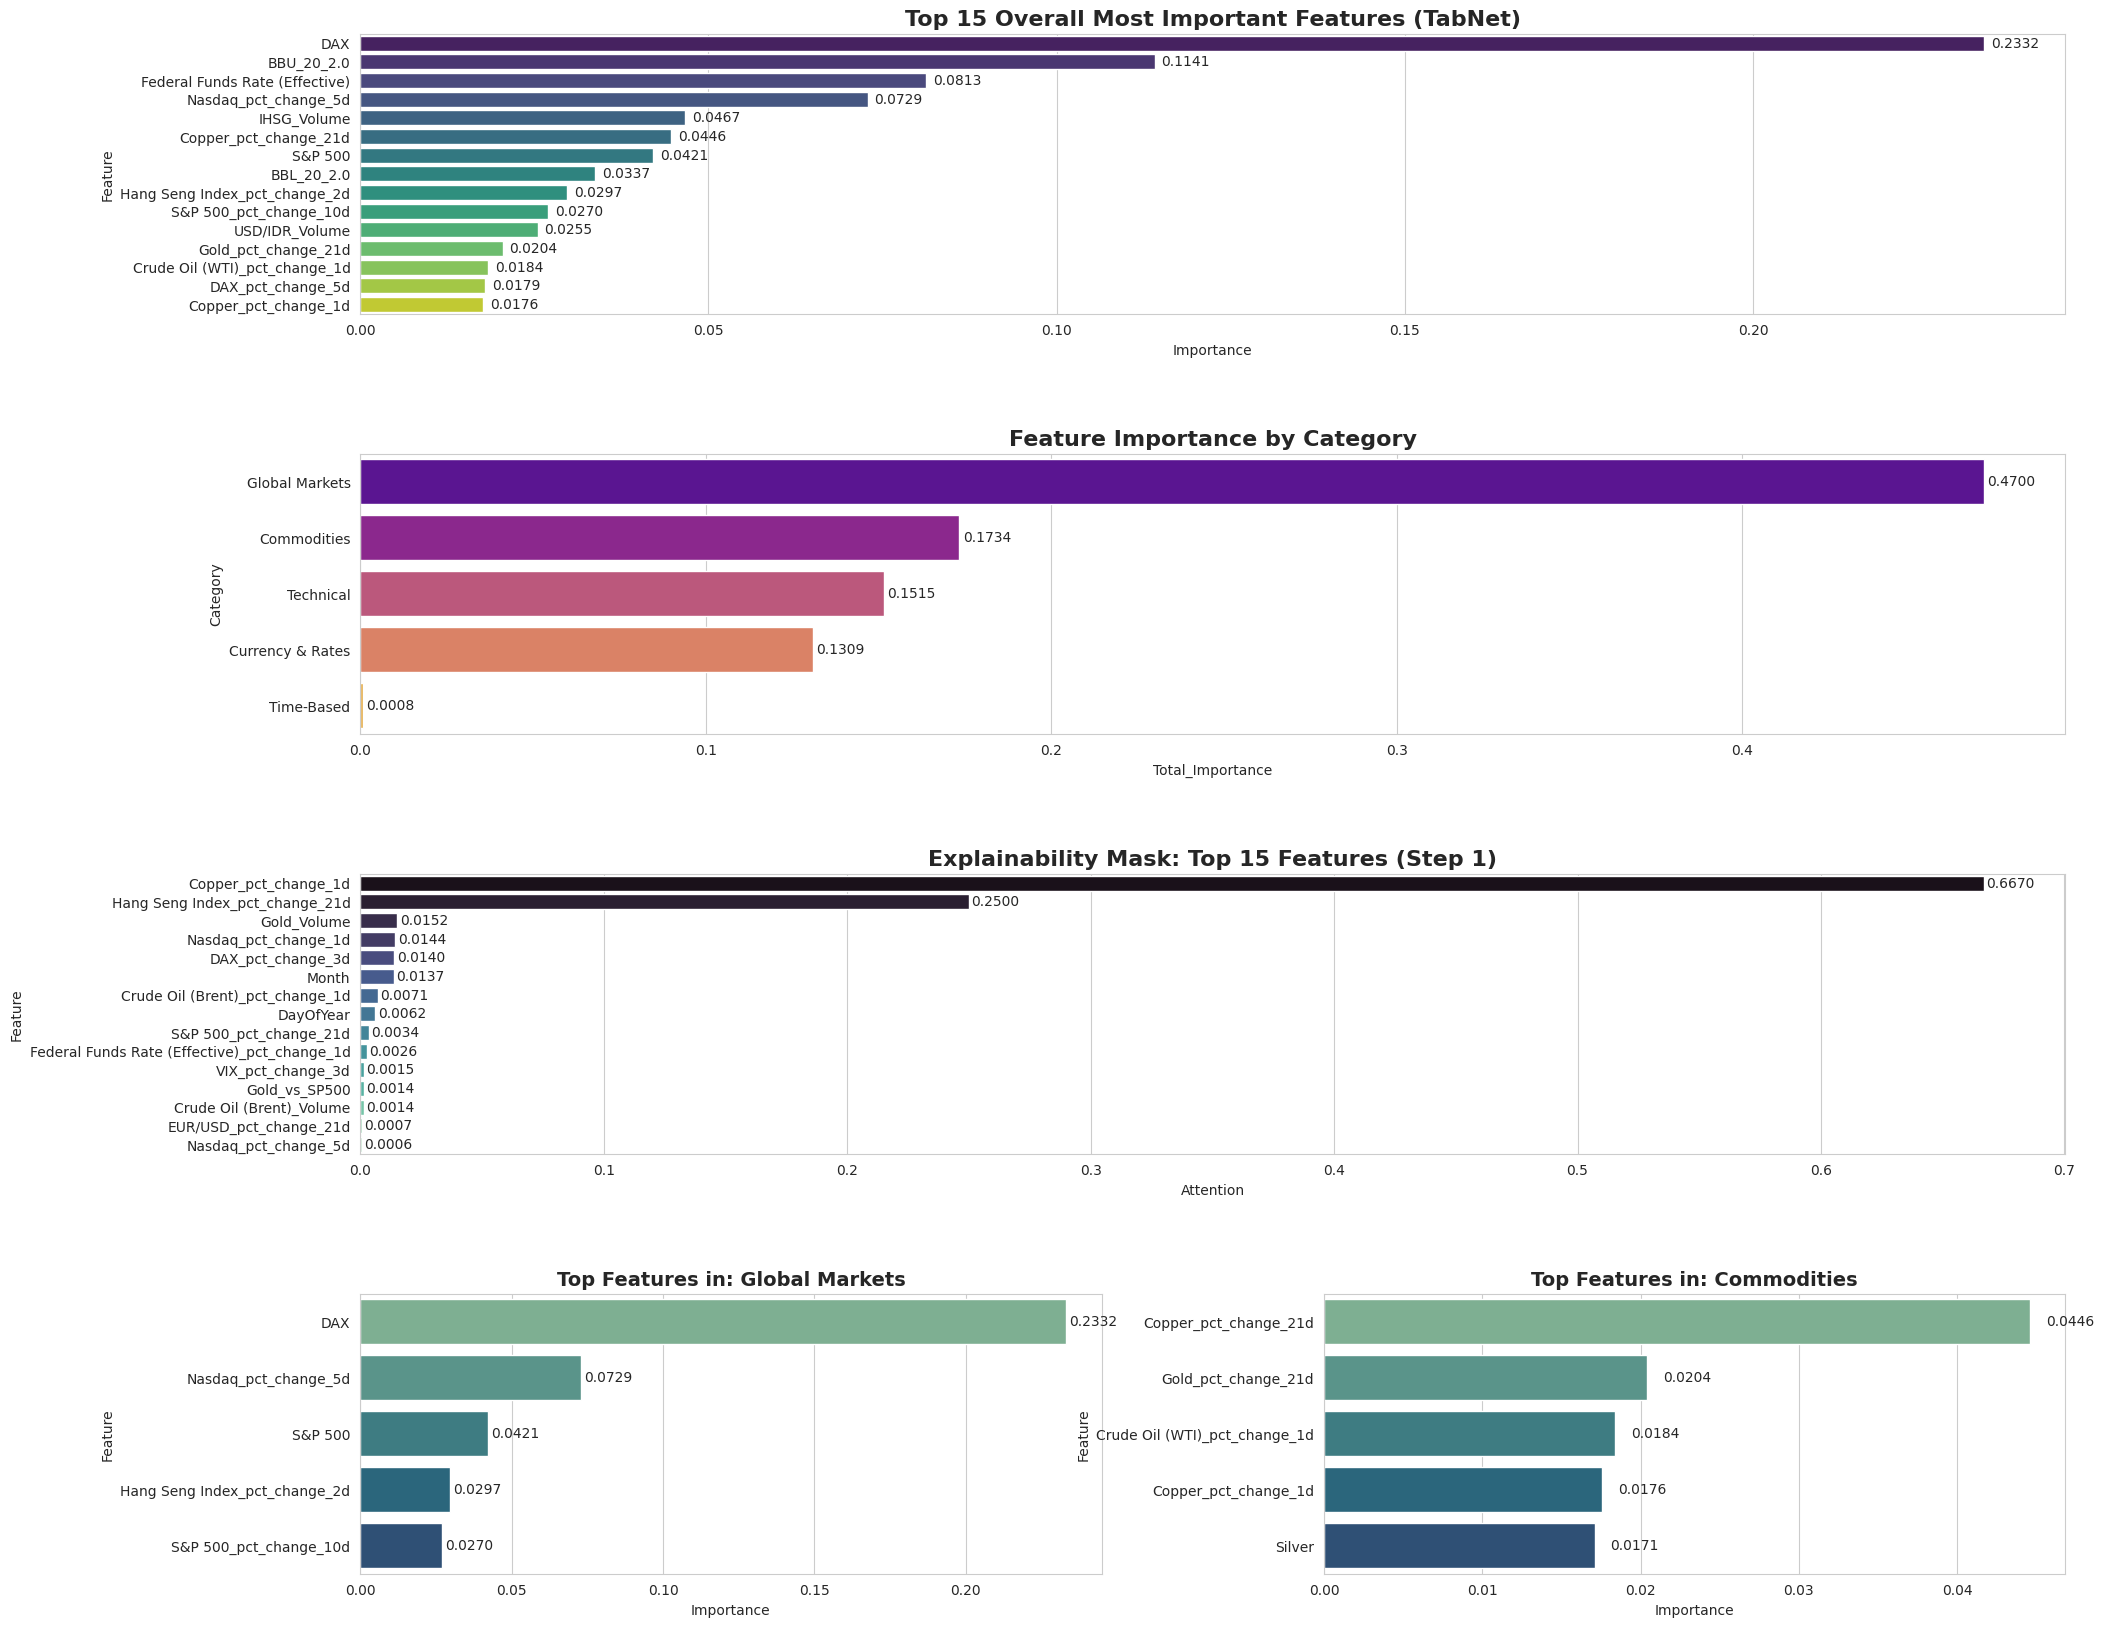

In [9]:
# ===================================================================
# 8. TabNet Feature Importance & Categorical Analysis (RESTORED)
# ===================================================================
print("\nPerforming TabNet categorical analysis...")

importance_df = pd.DataFrame({'Feature': features, 'Importance': final_tabnet.feature_importances_}).sort_values('Importance', ascending=False)

categories_map = {
    'Technical': [c for c in features if any(x in c for x in ['RSI', 'ATR', 'MACD', 'BBL', 'BBM', 'BBU'])],
    'Global Markets': [f for f in features if any(m in f for m in ['S&P 500', 'Nasdaq', 'DAX', 'VIX', 'Hang Seng'])],
    'Commodities': [f for f in features if any(m in f for m in ['Crude Oil', 'Gold', 'Copper', 'Silver'])],
    'Currency & Rates': [f for f in features if any(m in f for m in ['IDR', 'EURUSD', 'Federal Funds Rate'])],
    'Time-Based': ['DayOfWeek', 'Month', 'WeekOfYear']
}

category_importance = {}
for category, cat_features in categories_map.items():
    existing_features = [f for f in cat_features if f in importance_df['Feature'].values]
    category_importance[category] = importance_df[importance_df['Feature'].isin(existing_features)]['Importance'].sum()

category_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Total_Importance']).sort_values('Total_Importance', ascending=False)

# --- ADDED: Print statements for the data behind the plots ---
print("\n--- Top 15 Overall Feature Importance (TabNet) ---")
print(importance_df.head(15).to_string())
print("\n--- Feature Importance by Category ---")
print(category_df.to_string())


# --- Visualization Dashboard ---
fig = plt.figure(figsize=(22, 20))
gs = fig.add_gridspec(4, 2, hspace=0.5, wspace=0.3)

# Plot 1: Overall Top 15 Features
ax1 = fig.add_subplot(gs[0, :])
top_15_overall = importance_df.head(15)
sns.barplot(data=top_15_overall, x='Importance', y='Feature', ax=ax1, palette='viridis')
ax1.set_title('Top 15 Overall Most Important Features (TabNet)', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

# Plot 2: Importance by Category
ax2 = fig.add_subplot(gs[1, :])
sns.barplot(data=category_df, x='Total_Importance', y='Category', ax=ax2, palette='plasma')
ax2.set_title('Feature Importance by Category', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

# --- UPDATED: Readable Explainability Mask Visualization ---
ax3 = fig.add_subplot(gs[2, :])
explain_matrix, masks = final_tabnet.explain(X_test_tabular)
# Get the attention scores for the first decision step and average them across all test samples
mask_step1_avg = np.mean(masks[0], axis=0)
mask_df = pd.DataFrame({'Feature': features, 'Attention': mask_step1_avg}).sort_values('Attention', ascending=False)
sns.barplot(data=mask_df.head(15), x='Attention', y='Feature', ax=ax3, palette='mako')
ax3.set_title('Explainability Mask: Top 15 Features (Step 1)', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax3.patches:
    width = p.get_width()
    ax3.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')


top_categories = category_df['Category'].head(2).tolist()
axes_cat = [fig.add_subplot(gs[3, 0]), fig.add_subplot(gs[3, 1])]
for i, category in enumerate(top_categories):
    cat_features = categories_map.get(category, [])
    cat_df = importance_df[importance_df['Feature'].isin(cat_features)].head(5)
    ax = axes_cat[i]
    sns.barplot(data=cat_df, x='Importance', y='Feature', ax=ax, palette='crest')
    ax.set_title(f'Top Features in: {category}', fontsize=14, fontweight='bold')
    # Add values to bars
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')


plt.tight_layout()
plt.show()
